In [18]:
import os
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from prophet.utilities import regressor_coefficients

from bristor_modeling import create_forecast

load_dotenv()


True

In [2]:
df = pd.read_csv('dataset.csv', sep=',')
df = df.fillna(0)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

<Axes: xlabel='Date'>

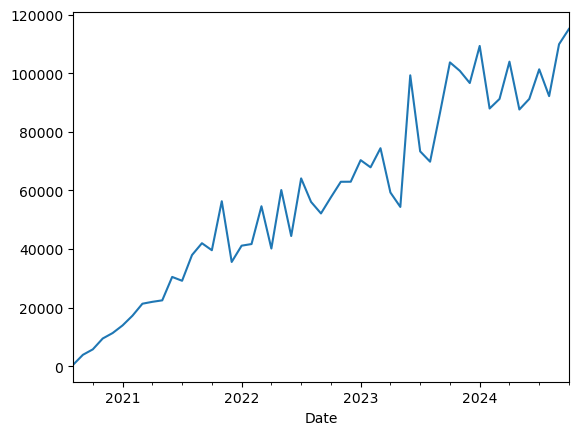

In [4]:
df.set_index('Date')['Ex-Factory volumes'].plot()

This time series is clearly not stationary, does not have a strong seasonality but there is an upwards trend

## Feature selection

In [5]:
regressors = ['BRISTOR_Email',
       'BRISTOR_Face to face call', 'BRISTOR_Mail', 'BRISTOR_Remote call',
       'BRISTOR_Telephone', 'BRISTOR_Indication A_Days of Treatment',
       'BRISTOR_Indication B_Days of Treatment',
       'Competitors_Indication A_Days of Treatment',
       'BRISTOR_Indication A_New Patient #',
       'BRISTOR_Indication A_New Patient %',
       'BRISTOR_Indication A_Total patients #',
       'BRISTOR_Indication A_Total patients %',
       'BRISTOR_Indication B_New Patient #',
       'BRISTOR_Indication B_New Patient %',
       'BRISTOR_Indication B_Total patients #',
       'BRISTOR_Indication B_Total patients %',
       'Competitors_Indication A_New Patient #',
       'Competitors_Indication A_New Patient %',
       'Competitors_Indication A_Total patients #',
       'Competitors_Indication A_Total patients %',
       'Competitors_Indication B_New Patient #',
       'Competitors_Indication B_New Patient %',
       'Competitors_Indication B_Total patients #',
       'Competitors_Indication B_Total patients %', 'BRISTOR_Indication A',
       'BRISTOR_Indication B', 'Competitors_Indication A']


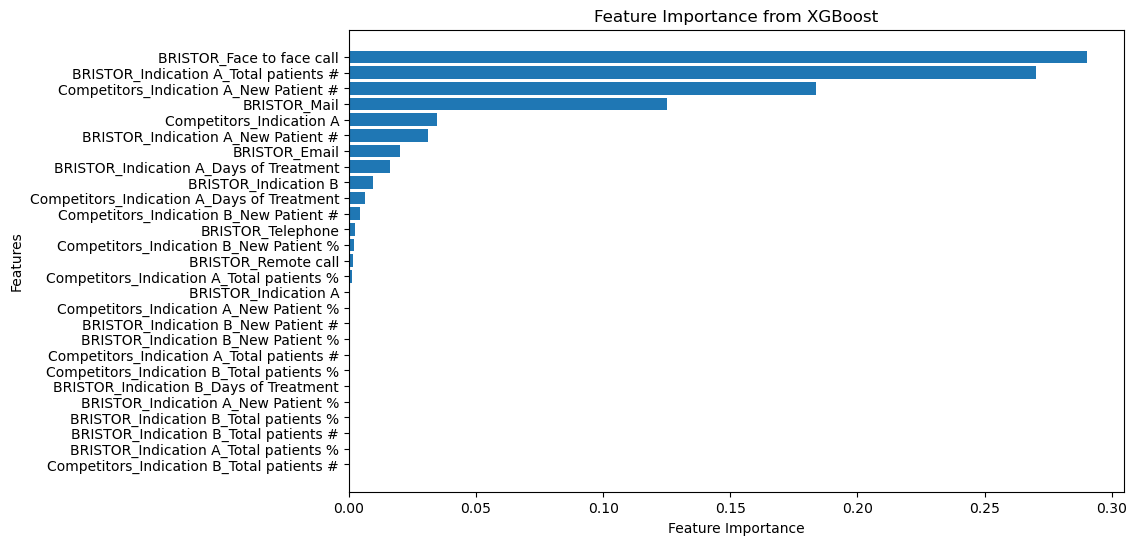

Selected Features for Prophet: ['BRISTOR_Face to face call', 'BRISTOR_Indication A_Total patients #', 'Competitors_Indication A_New Patient #', 'BRISTOR_Mail', 'Competitors_Indication A', 'BRISTOR_Indication A_New Patient #', 'BRISTOR_Email', 'BRISTOR_Indication A_Days of Treatment', 'BRISTOR_Indication B', 'Competitors_Indication A_Days of Treatment']


In [6]:
X = df[regressors]
y = df['Ex-Factory volumes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Feature importance
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': regressors, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Top 10 important features
selected_features = importance_df['Feature'].head(10).tolist()

print(f"Selected Features for Prophet: {selected_features}")

**Why Remove Collinearity in Time Series Forecasting?**  

- **Improves model stability**: Prevents unstable or unreliable coefficients.  
- **Enhances prediction accuracy**: Reduces overfitting and improves generalization.  
- **Increases interpretability**: Clarifies the impact of each regressor.  
- **Avoids redundancy**: Removes unnecessary or duplicate information.  
- **Boosts efficiency**: Simplifies the model and reduces computational complexity.  

Filtered Features for Prophet: ['BRISTOR_Face to face call', 'Competitors_Indication A_New Patient #', 'BRISTOR_Mail', 'BRISTOR_Email', 'BRISTOR_Indication B', 'Competitors_Indication A_Days of Treatment']
Removed Correlated Features: {'BRISTOR_Indication A_New Patient #', 'BRISTOR_Indication A_Days of Treatment', 'Competitors_Indication A', 'BRISTOR_Indication A_Total patients #'}


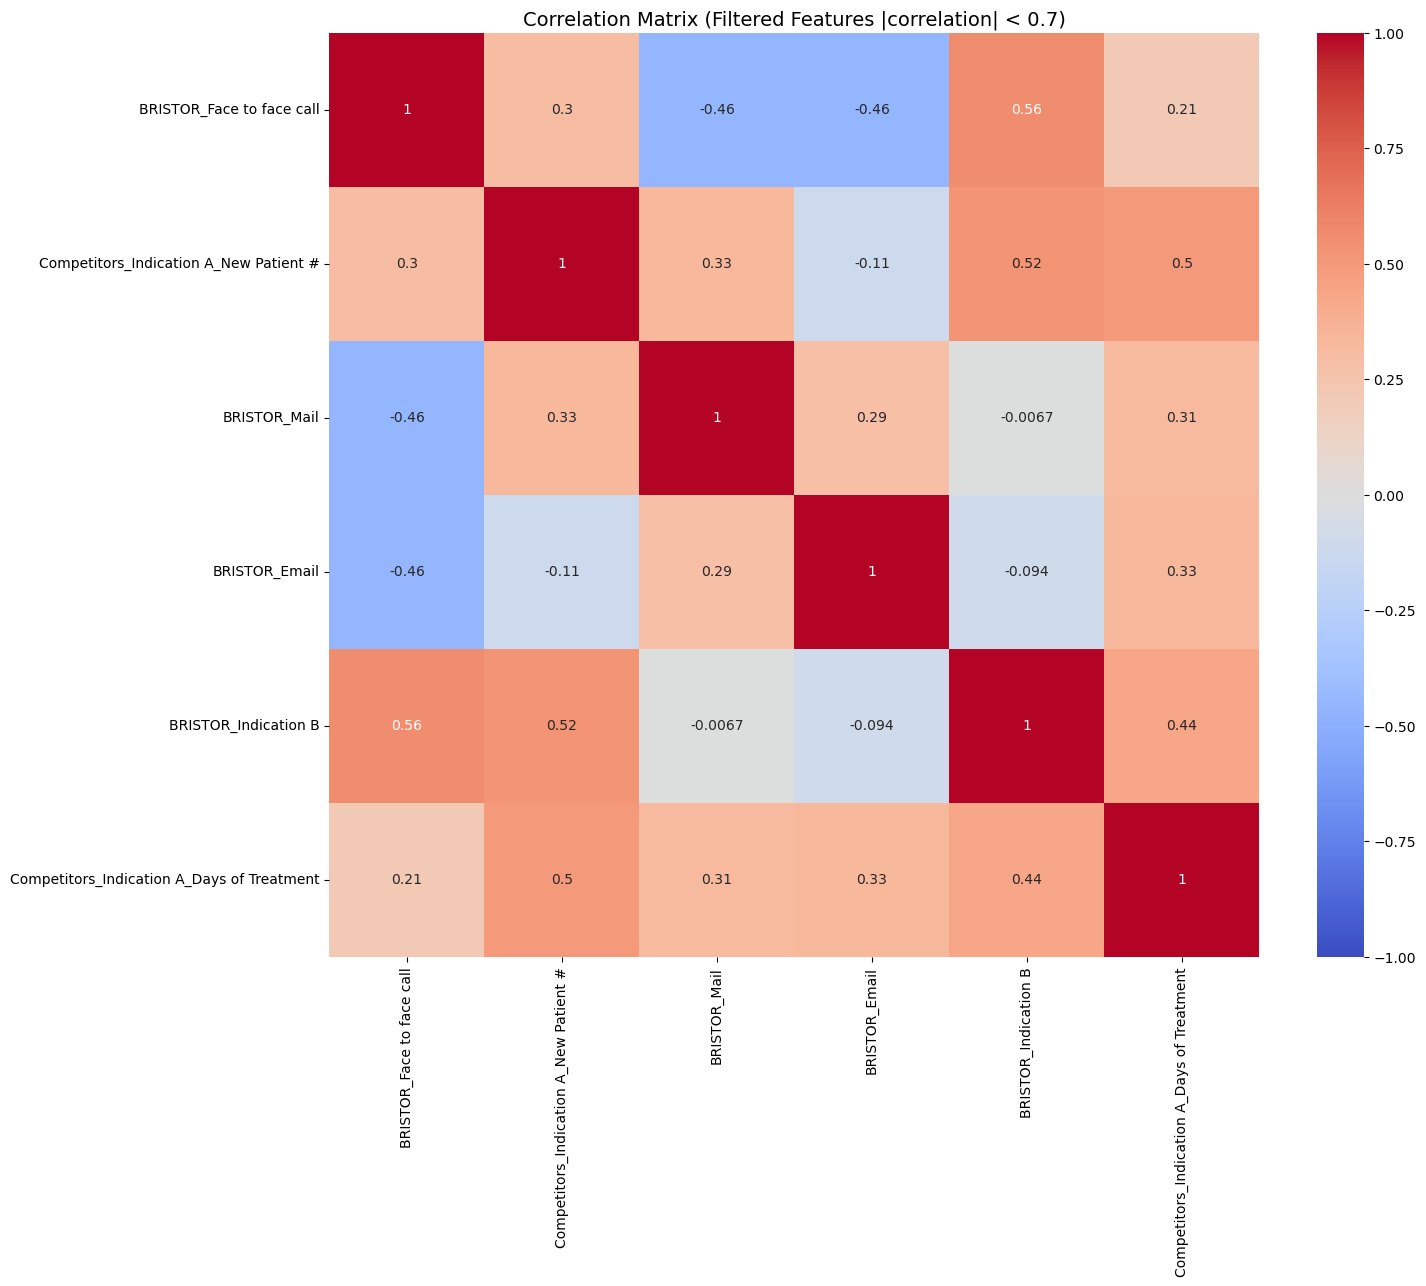

In [7]:
# Correlation matrix for features
corr_matrix = df[selected_features].corr()

correlated_features = set()
threshold = 0.75

target_corr = df[selected_features].corrwith(df['Ex-Factory volumes'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Delete the feature less important with the target
            if abs(target_corr[col_i]) > abs(target_corr[col_j]):
                correlated_features.add(col_j)
            else:
                correlated_features.add(col_i)

filtered_features = [col for col in selected_features if col not in correlated_features]

print(f"Filtered Features for Prophet: {filtered_features}")
print(f"Removed Correlated Features: {correlated_features}")

filtered_corr = df[filtered_features].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix (Filtered Features |correlation| < 0.7)', fontsize=14)
plt.show()

### COEFFICIENTS
- **BRISTOR_Email: -10.09**  
Each unit increase in this regressor decreases the forecast by 10.09 units. This indicates a direct negative impact.

- **BRISTOR_Face to face call: 0.03**  
A very small positive impact: each additional unit of this regressor increases the forecast by about 0.03 units. This value is negligible compared to other regressors.

- **BRISTOR_Mail: -2.72**  
Each unit increase in this regressor reduces the forecast by 2.72 units. It has a moderate negative impact.

- **BRISTOR_Remote call: 164.28**  
This is the regressor with the highest positive impact. Each additional unit increases the forecast by 164.28 units. It is likely one of the most important variables in the model.

- **BRISTOR_Telephone: 63.88**  
Each additional unit of this regressor increases the forecast by 63.88 units, indicating a significant positive impact.

- **Competitors_Indication A_Days of Treatment: 0.00169**  
A very small positive impact, negligible compared to other regressors.

- **BRISTOR_Indication A_New Patient #: -33.31**  
Each unit increase in this regressor reduces the forecast by 33.31 units, indicating a significant negative impact.

In [8]:
#Reload the model
with open('prophet_model_bristor.pkl', 'rb') as f:
    m = pickle.load(f)

coefficients = regressor_coefficients(m)
coefficients


,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,BRISTOR_Email,additive,5.343725e+02,-10.090703,-10.090703,-10.090703
1,BRISTOR_Face to face call,additive,1.376176e+03,0.031099,0.031099,0.031099
2,BRISTOR_Mail,additive,6.252157e+02,-2.723232,-2.723232,-2.723232
3,BRISTOR_Remote call,additive,2.331373e+01,164.276731,164.276731,164.276731
4,BRISTOR_Telephone,additive,1.450588e+02,63.888851,63.888851,63.888851
5,Competitors_Indication A_Days of Treatment,additive,3.283727e+06,0.001690,0.001690,0.001690
6,BRISTOR_Indication A_New Patient #,additive,1.117647e+02,-33.308174,-33.308174,-33.308174


### Forecasts

In [9]:
file_path = 'BRISTOR_Zegoland.xlsx'

excel_file = pd.ExcelFile(file_path)

forecast_volumes_df = pd.read_excel(file_path, sheet_name='Forecast volumes')

transformed_df = forecast_volumes_df[['Forecast Algorithm', 'Date', 'Value']]

transformed_df

,Forecast Algorithm,Date,Value
0,univariate xgboost,2024-11-01,104504.726562
1,univariate xgboost,2024-12-01,105558.750000
2,univariate xgboost,2025-01-01,105818.843750
3,univariate xgboost,2025-02-01,102342.312500
4,univariate xgboost,2025-03-01,102478.656250
...,...,...,...
135,optimized arima,2025-08-01,127779.169675
136,optimized arima,2025-09-01,138988.748738
137,optimized arima,2025-10-01,146133.353743
138,optimized arima,2025-11-01,138773.661194


In [10]:
REGRESSORS = [
        'BRISTOR_Email',
        'BRISTOR_Face to face call',
        'BRISTOR_Mail',
        'BRISTOR_Remote call',
        'BRISTOR_Telephone',
        'Competitors_Indication A_Days of Treatment',
        'BRISTOR_Indication A_New Patient #'
    ]

In [ ]:
fixed_values = {
    'BRISTOR_Email': 10,
    'Competitors_Indication A_Days of Treatment': 5
    }

forecast, forecast_complete = create_forecast(m, REGRESSORS, "2024-11-01", "2025-12-01",
    fixed_regressors=fixed_values,
    default_value=0)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

prophet_forecast = forecast.rename(columns={
    'ds': 'Date',
    'yhat': 'Value'
})
prophet_forecast['Forecast Algorithm'] = 'prophet'

final_df = pd.concat([transformed_df, prophet_forecast[['Forecast Algorithm', 'Date', 'Value']]], ignore_index=True)
final_df

,Forecast Algorithm,Date,Value
0,univariate xgboost,2024-11-01,104504.726562
1,univariate xgboost,2024-12-01,105558.750000
2,univariate xgboost,2025-01-01,105818.843750
3,univariate xgboost,2025-02-01,102342.312500
4,univariate xgboost,2025-03-01,102478.656250
...,...,...,...
149,prophet,2025-08-01,125411.587882
150,prophet,2025-09-01,129519.509048
151,prophet,2025-10-01,134600.780522
152,prophet,2025-11-01,139226.618155


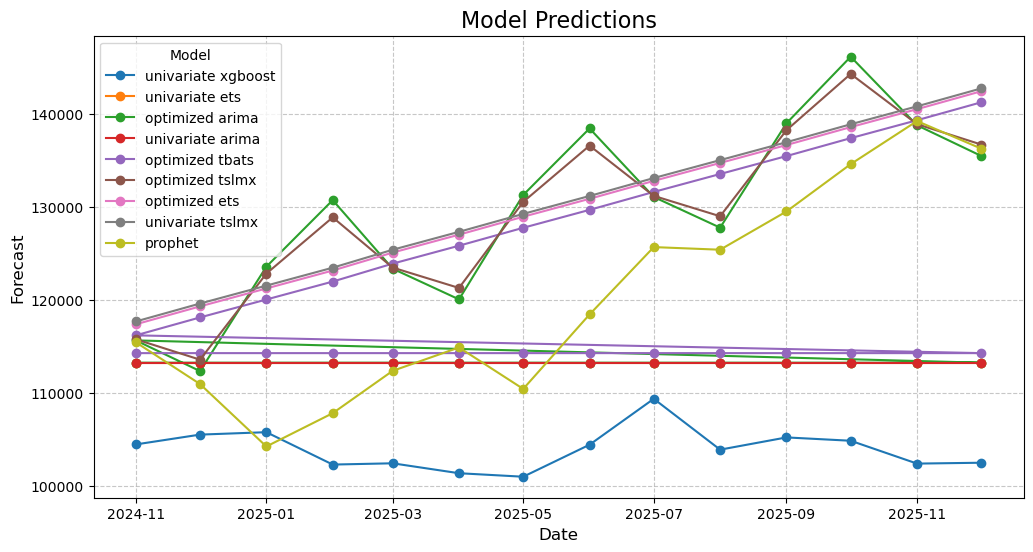

In [ ]:
final_df['Date'] = pd.to_datetime(final_df['Date'])

plt.figure(figsize=(12, 6))

for model in final_df['Forecast Algorithm'].unique():
    model_data = final_df[final_df['Forecast Algorithm'] == model]
    plt.plot(model_data['Date'], model_data['Value'], label=model, marker='o')

plt.title('Model Predictions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecast', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)

plt.show()